In [113]:
import pandas as pd
import numpy as np
import json

# plotting
import matplotlib.pyplot as plt

#opening data
import os
import pathlib
import warnings

#used for plots
from mplsoccer import Pitch
from scipy.stats import binned_statistic_2d

pd.options.mode.chained_assignment = None
warnings.filterwarnings('ignore')

# Opening data

In [114]:
notebook_dir = pathlib.Path().absolute()
events_path = os.path.join(notebook_dir.parent, "wyscout-data", "events", "events_England.json")

with open(events_path) as f:
    events = json.load(f)

df = pd.DataFrame(events)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 643150 entries, 0 to 643149
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   eventId       643150 non-null  int64  
 1   subEventName  643150 non-null  object 
 2   tags          643150 non-null  object 
 3   playerId      643150 non-null  int64  
 4   positions     643150 non-null  object 
 5   matchId       643150 non-null  int64  
 6   eventName     643150 non-null  object 
 7   teamId        643150 non-null  int64  
 8   matchPeriod   643150 non-null  object 
 9   eventSec      643150 non-null  float64
 10  subEventId    643150 non-null  object 
 11  id            643150 non-null  int64  
dtypes: float64(1), int64(5), object(6)
memory usage: 58.9+ MB


# Actions moving the ball

- Filter out actions that move the ball
- Remove passes that went out of play
- Create new columns for coordinates
- Plot locations in a histogram
- Store number of actions in each bin in *move_count* array

In [115]:
# Add new column for next event (used to filter out passes that went out of play)
next_event = df.shift(-1, fill_value=0)
df["nextEvent"] = next_event["subEventName"]
df["kickedOut"] = df.apply(lambda x: 1 if x.nextEvent == "Ball out of the field" else 0, axis=1)

# Get actions that move the ball
move_df = df[df["subEventName"].isin(["Simple pass", "High pass", "Head pass", "Smart pass", "Cross"])]

# Filter out actions that end in out of play
passes_to_delete = move_df[move_df["kickedOut"] == 1]
move_df = move_df.drop(passes_to_delete.index)
passes_to_delete.head()


,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id,nextEvent,kickedOut
108,8,High pass,[{'id': 1802}],7868,"[{'y': 14, 'x': 40}, {'y': 100, 'x': 67}]",2499719,Pass,1609,1H,364.985980,83,177959270,Ball out of the field,1
143,8,High pass,"[{'id': 901}, {'id': 1802}]",14853,"[{'y': 4, 'x': 63}, {'y': 96, 'x': 100}]",2499719,Pass,1631,1H,498.389197,83,177959354,Ball out of the field,1
189,8,High pass,[{'id': 1802}],370224,"[{'y': 76, 'x': 53}, {'y': 87, 'x': 95}]",2499719,Pass,1609,1H,656.021673,83,177959368,Ball out of the field,1
217,8,Simple pass,[{'id': 1802}],25413,"[{'y': 38, 'x': 30}, {'y': 0, 'x': 28}]",2499719,Pass,1609,1H,752.105957,85,177959390,Ball out of the field,1
533,8,Simple pass,[{'id': 1802}],3319,"[{'y': 57, 'x': 31}, {'y': 0, 'x': 30}]",2499719,Pass,1609,1H,1650.546495,85,177959757,Ball out of the field,1


In [116]:
# Create new columns for coordinates
move_df["x"] = move_df["positions"].apply(lambda cell: (cell[0]["x"]) * 105/100)
move_df["y"] = move_df["positions"].apply(lambda cell: (100 - cell[0]["y"]) * 68/100)
move_df["endX"] = move_df["positions"].apply(lambda cell: (cell[1]["x"]) * 105/100)
move_df["endY"] = move_df["positions"].apply(lambda cell: (100 - cell[1]["y"]) * 68/100)

# Remove actions that end in the corners of the pitch (right corners on horizontal pitch)
move_df = move_df[((move_df["endX"] != 0) & (move_df["endY"] != 68)) & ((move_df["endX"] != 105) & (move_df["endY"] != 0))]
move_df.shape

(307333, 18)

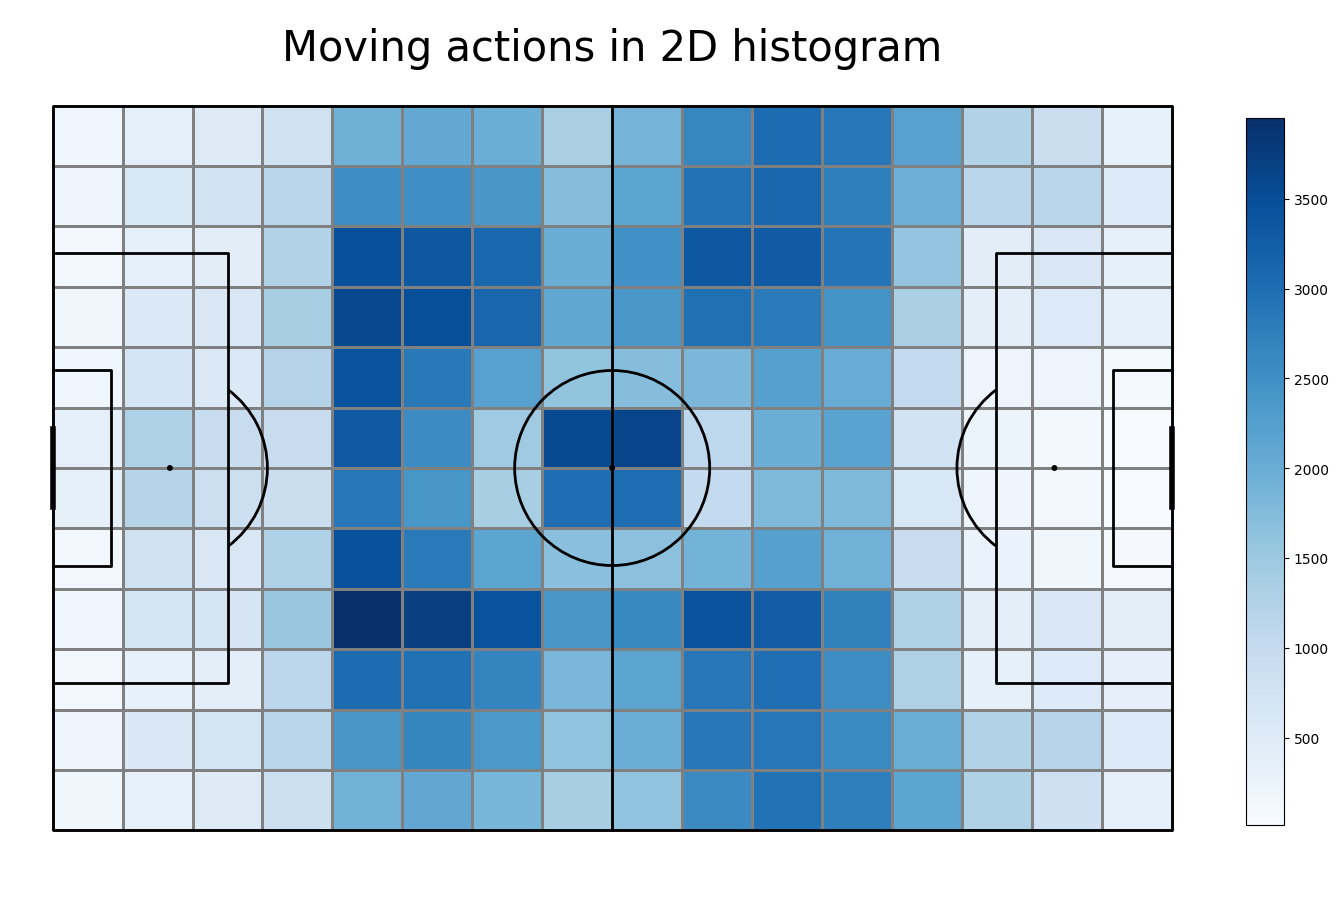

In [117]:
# Init pitch
pitch = Pitch(line_color='black',pitch_type='custom', pitch_length=105, pitch_width=68, line_zorder=2)
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)

# Create bins
move = pitch.bin_statistic(move_df["x"], move_df["y"], statistic='count', bins=(16, 12), normalize=False)

# Get the move count array
move_count = move["statistic"]

# Plot bins in heatmap
pcm  = pitch.heatmap(move, cmap='Blues', edgecolor='grey', ax=ax['pitch'])

# Legend
ax_cbar = fig.add_axes((1, 0.093, 0.03, 0.786))
cbar = plt.colorbar(pcm, cax=ax_cbar)

fig.suptitle('Moving actions in 2D histogram', fontsize = 30)
plt.show()

# Shots

- Filter them out of data
- Create new columns for locations
- Store number of shots in each bin in *shot_count* array

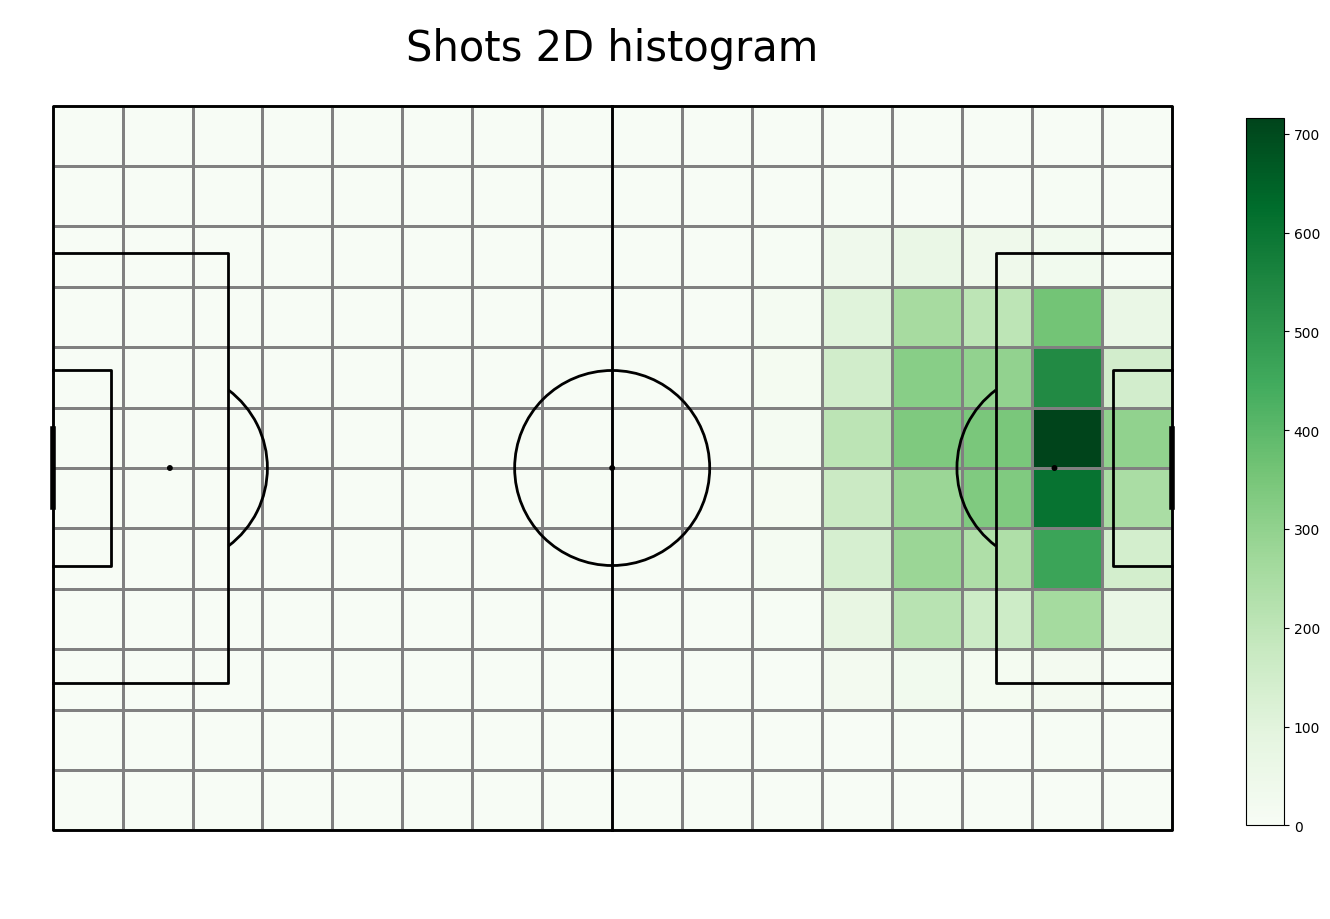

In [118]:
# Get shots
shot_df = df[df["subEventName"] == "Shot"]

# Create new columns for location
shot_df["x"] = shot_df["positions"].apply(lambda cell: (cell[0]["x"]) * 105/100)
shot_df["y"] = shot_df["positions"].apply(lambda cell: (100 - cell[0]["y"]) * 68/100)

# Create bins
shot = pitch.bin_statistic(shot_df["x"], shot_df["y"], statistic="count", bins=(16, 12), normalize=False)

# Get the shot_count array
shot_count = shot["statistic"]

# Create 2D histogram
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)
pcm  = pitch.heatmap(shot, cmap='Greens', edgecolor='grey', ax=ax['pitch'])

# Add legend to plot
ax_cbar = fig.add_axes((1, 0.093, 0.03, 0.786))
cbar = plt.colorbar(pcm, cax=ax_cbar)

fig.suptitle('Shots 2D histogram', fontsize = 30)
plt.show()

# Goals

- Filter them out of shots data     (locations columns already there)
- Store number of goals in each bin in *goal_count* array

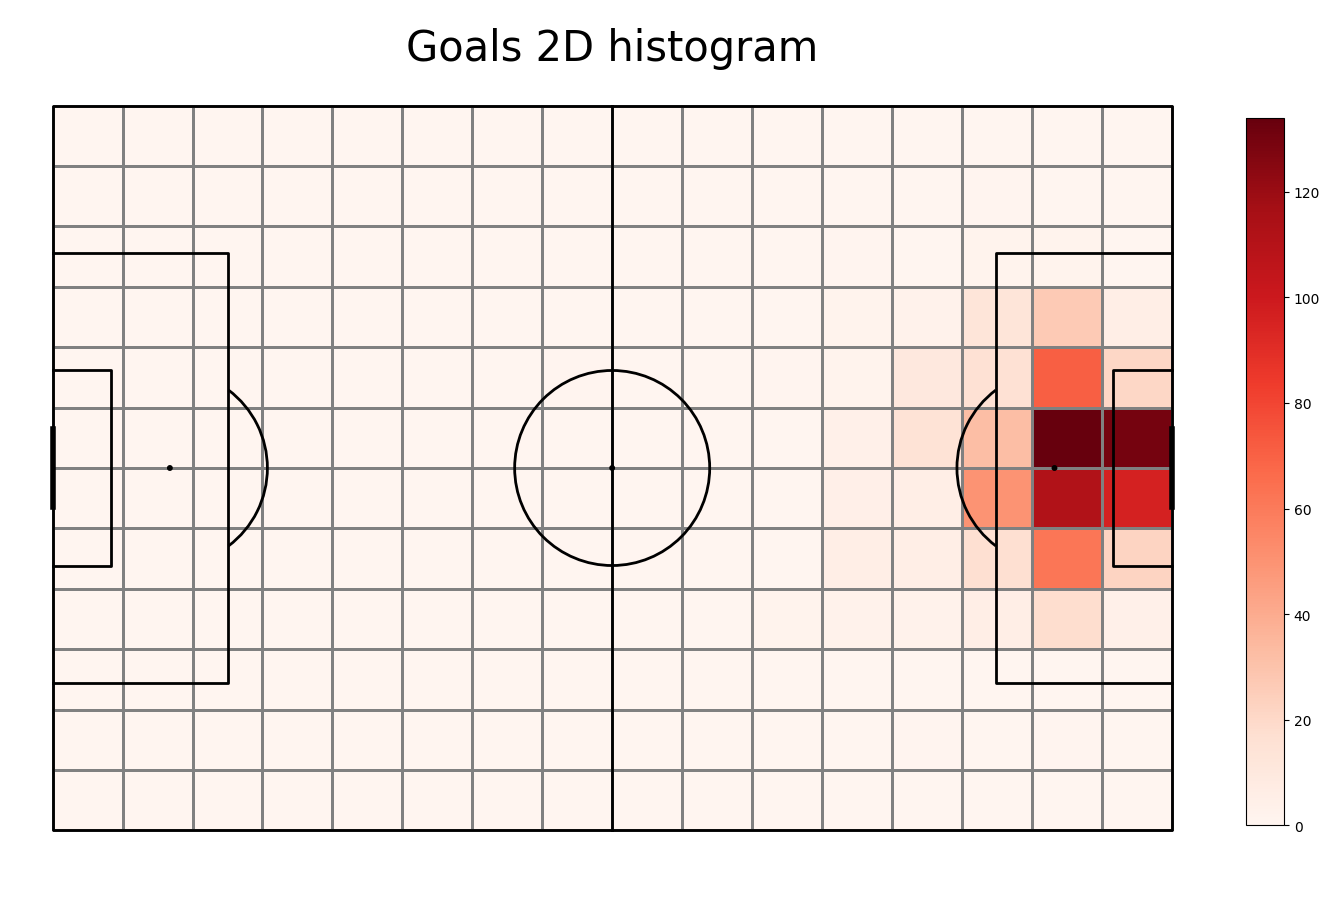

In [119]:
# Get goals
goal_df = shot_df[shot_df.apply(lambda x: {'id': 101} in x['tags'], axis=1)]

# Create bins
goal = pitch.bin_statistic(goal_df["x"], goal_df["y"], statistic="count", bins=(16, 12), normalize=False)

# Get the shot_count array
goal_count = goal["statistic"]

# Create 2D histogram
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)
pcm  = pitch.heatmap(goal, cmap='Reds', edgecolor='grey', ax=ax['pitch'])

# Add legend to plot
ax_cbar = fig.add_axes((1, 0.093, 0.03, 0.786))
cbar = plt.colorbar(pcm, cax=ax_cbar)

fig.suptitle('Goals 2D histogram', fontsize = 30)
plt.show()

# Move probability

- Kans berekenen op een move in plaats van een shot: move_count/(move_count + shot_count)
- Kolom "statistic" van move df overschrijven -> bins krijgen nu de probability in plaats van de move count
- 2D histogram plotten

=> Geeft voor elke bin de kans dat de volgende actie een move is (en geen shot)

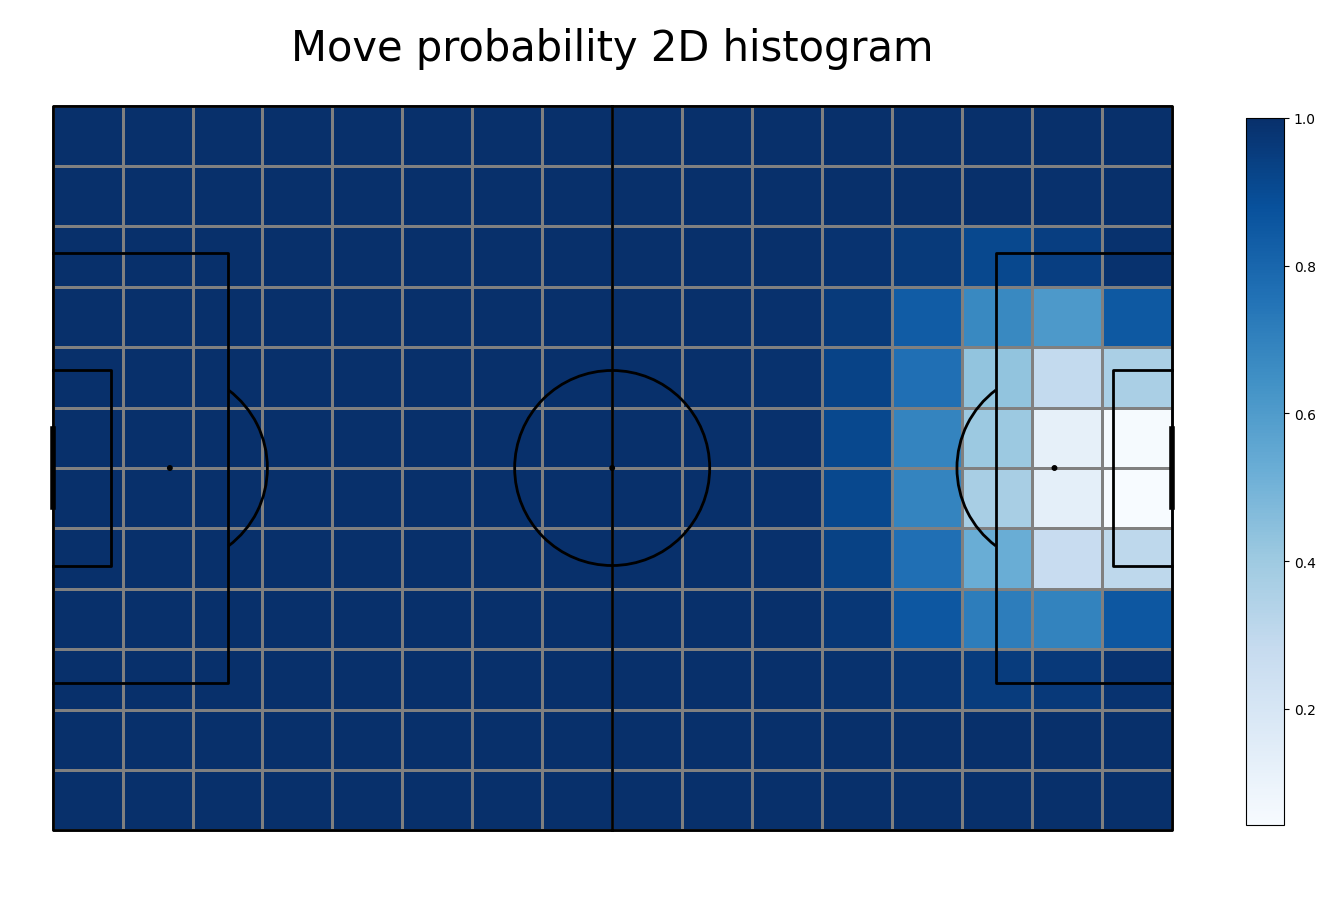

In [120]:
# Calculate move probability
move_prob = move_count/(move_count + shot_count)

# Overwrite statistic column to move df
move["statistic"] = move_prob

# Plot 2D histogram
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)
pcm  = pitch.heatmap(move, cmap='Blues', edgecolor='grey', ax=ax['pitch'])

# Add legend to plot
ax_cbar = fig.add_axes((1, 0.093, 0.03, 0.786))
cbar = plt.colorbar(pcm, cax=ax_cbar)

fig.suptitle('Move probability 2D histogram', fontsize = 30)
plt.show()

# Shot probability

- Kans berekenen op een shot in plaats van een shot: shot_count/(move_count + shot_count)
- Kolom "statistic" van shot df overschrijven -> bins krijgen nu de probability in plaats van de shot count
- 2D histogram plotten

=> Geeft voor elke bin de kans dat de volgende actie een shot is (en geen move)

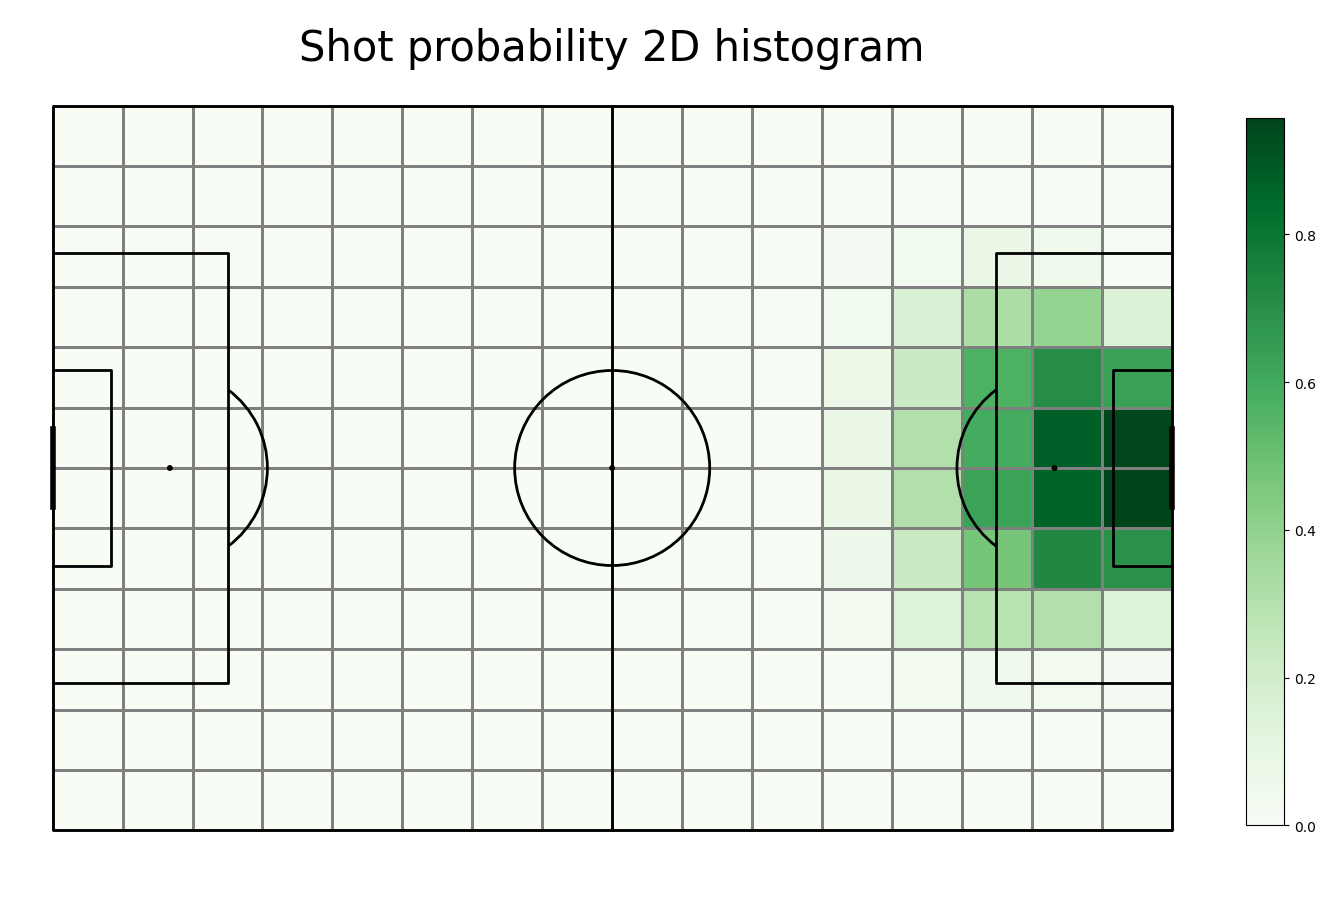

In [121]:
# Calculate shot probability
shot_prob = 1 - move_prob

# Overwrite statistic column to shot df
shot["statistic"] = shot_prob

# Plot 2D histogram
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)
pcm  = pitch.heatmap(shot, cmap='Greens', edgecolor='grey', ax=ax['pitch'])

# Add legend to plot
ax_cbar = fig.add_axes((1, 0.093, 0.03, 0.786))
cbar = plt.colorbar(pcm, cax=ax_cbar)

fig.suptitle('Shot probability 2D histogram', fontsize = 30)
plt.show()

# Goal probability

- Kans berekenen op een goal in plaats van een shot: goal_count/shot_count
- Kolom "statistic" van goal df overschrijven -> bins krijgen nu de probability in plaats van de count
- 2D histogram plotten

=> Geeft voor elke bin de kans dat de volgende actie een doelpunt is (en geen shot) -> vereenvoudigd xG model

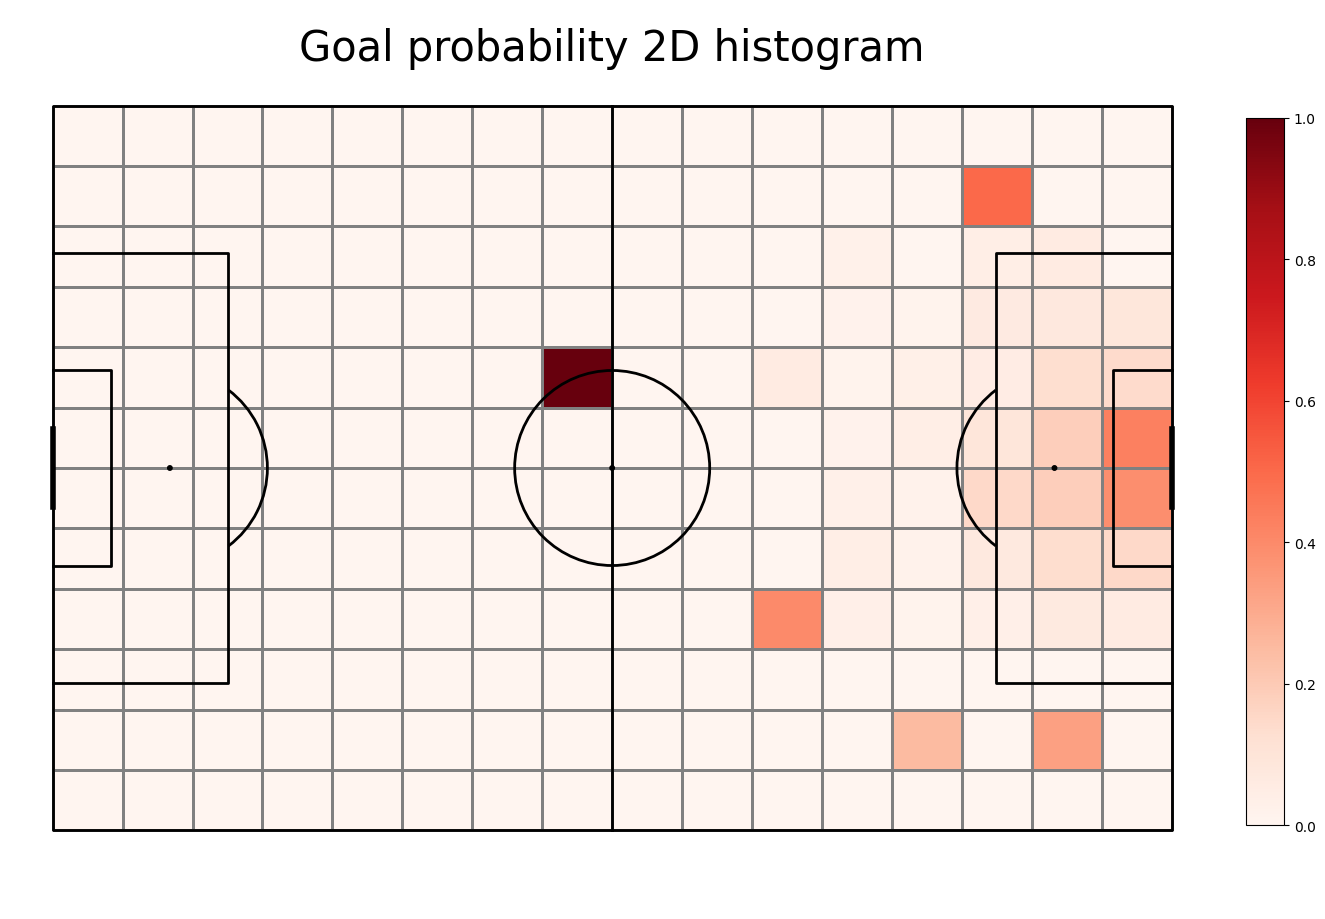

In [122]:
# Calculate goal probability
goal_prob = goal_count/shot_count
goal_prob[np.isnan(goal_prob)] = 0

# Overwrite statistic column to goal df
goal["statistic"] = goal_prob

# Plot 2D histogram
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)
pcm  = pitch.heatmap(goal, cmap='Reds', edgecolor='grey', ax=ax['pitch'])

# Add legend to plot
ax_cbar = fig.add_axes((1, 0.093, 0.03, 0.786))
cbar = plt.colorbar(pcm, cax=ax_cbar)

fig.suptitle('Goal probability 2D histogram', fontsize = 30)
plt.show()

# Transition matrices

Voor alle 192 sectoren een transition matrix opstellen: kans berekenen dat de bal van één zone naar de andere zones gaat
- Elke move toekennen aan een bin op het veld
- Starting sectors groeperen en de total count ophalen voor elke sector (later gebruiken voor de kansberekening)
- Voor elke sector berekenen wat de kans is om naar een andere sector te gaan (voor alle sectors)

In [123]:
# Voor elke move de bin bepalen waar de actie start
move_df["start_sector"] = move_df.apply(lambda row: tuple([i[0] for i in binned_statistic_2d(np.ravel(row["x"]), np.ravel(row["y"]),
                                                               values = "None", statistic="count",
                                                               bins=(16, 12), range=[[0, 105], [0, 68]],
                                                               expand_binnumbers=True)[3]]), axis = 1)

# Voor elke move de bin bepalen waar de actie eindigt
move_df["end_sector"] = move_df.apply(lambda row: tuple([i[0] for i in binned_statistic_2d(np.ravel(row["endX"]), np.ravel(row["endY"]),
                                                               values = "None", statistic="count",
                                                               bins=(16, 12), range=[[0, 105], [0, 68]],
                                                               expand_binnumbers=True)[3]]), axis = 1)

df_count_starts = move_df.groupby(["start_sector"])["eventId"].count().reset_index()
df_count_starts.rename(columns = {'eventId':'count_starts'}, inplace=True)
df_count_starts.head()

,start_sector,count_starts
0,"(1, 1)",168
1,"(1, 2)",224
2,"(1, 3)",134
3,"(1, 4)",162
4,"(1, 5)",136


In [124]:
move_df.head()

,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id,nextEvent,kickedOut,x,y,endX,endY,start_sector,end_sector
0,8,Simple pass,[{'id': 1801}],25413,"[{'y': 49, 'x': 49}, {'y': 78, 'x': 31}]",2499719,Pass,1609,1H,2.758649,85,177959171,High pass,0,51.45,34.68,32.55,14.96,"(8, 7)","(5, 3)"
1,8,High pass,[{'id': 1801}],370224,"[{'y': 78, 'x': 31}, {'y': 75, 'x': 51}]",2499719,Pass,1609,1H,4.946850,83,177959172,Head pass,0,32.55,14.96,53.55,17.00,"(5, 3)","(9, 4)"
2,8,Head pass,[{'id': 1801}],3319,"[{'y': 75, 'x': 51}, {'y': 71, 'x': 35}]",2499719,Pass,1609,1H,6.542188,82,177959173,Head pass,0,53.55,17.00,36.75,19.72,"(9, 4)","(6, 4)"
3,8,Head pass,[{'id': 1801}],120339,"[{'y': 71, 'x': 35}, {'y': 95, 'x': 41}]",2499719,Pass,1609,1H,8.143395,82,177959174,Simple pass,0,36.75,19.72,43.05,3.40,"(6, 4)","(7, 1)"
4,8,Simple pass,[{'id': 1801}],167145,"[{'y': 95, 'x': 41}, {'y': 88, 'x': 72}]",2499719,Pass,1609,1H,10.302366,85,177959175,Simple pass,0,43.05,3.40,75.60,8.16,"(7, 1)","(12, 2)"


In [125]:
# Init transition matrices
transition_matrices = []

# Loop through df_count_starts to get the start sector and count
for i, row in df_count_starts.iterrows():
    # Get the start sector
    start_sector = row["start_sector"]
    
    # Get the count of actions starting there
    count_starts = row["count_starts"]
    
    # Get all events that start in this sector
    this_sector = move_df[move_df["start_sector"] == start_sector]

    # Group and count the end sectors
    df_count_ends = this_sector.groupby(["end_sector"])["eventId"].count().reset_index()
    df_count_ends.rename(columns = {'eventId':'count_ends'}, inplace=True)

    # Init transition matrix for this sector
    T_matrix = np.zeros((12, 16))
    
    # Loop through df_count_ends to fill the transition matrix
    for j, end_row in df_count_ends.iterrows():
        # Get the end sector
        end_sector = end_row["end_sector"]
        
        # Get the count actions ending there
        count_ends = end_row["count_ends"]
        
        # Access the correct position in the transition matrix (bin numbers start from 1) and 
        T_matrix[end_sector[1] - 1][end_sector[0] - 1] = count_ends
    
    # Now we have filled the matrix with count_ends (number of actions ending in sector j)
    # If we divide each element by count_starts (number of actions starting in sector i), we get the probability of ending in sector j if we start in sector i
    T_matrix = T_matrix / count_starts
    
    # Add the transition matrix to the list
    transition_matrices.append(T_matrix)
    

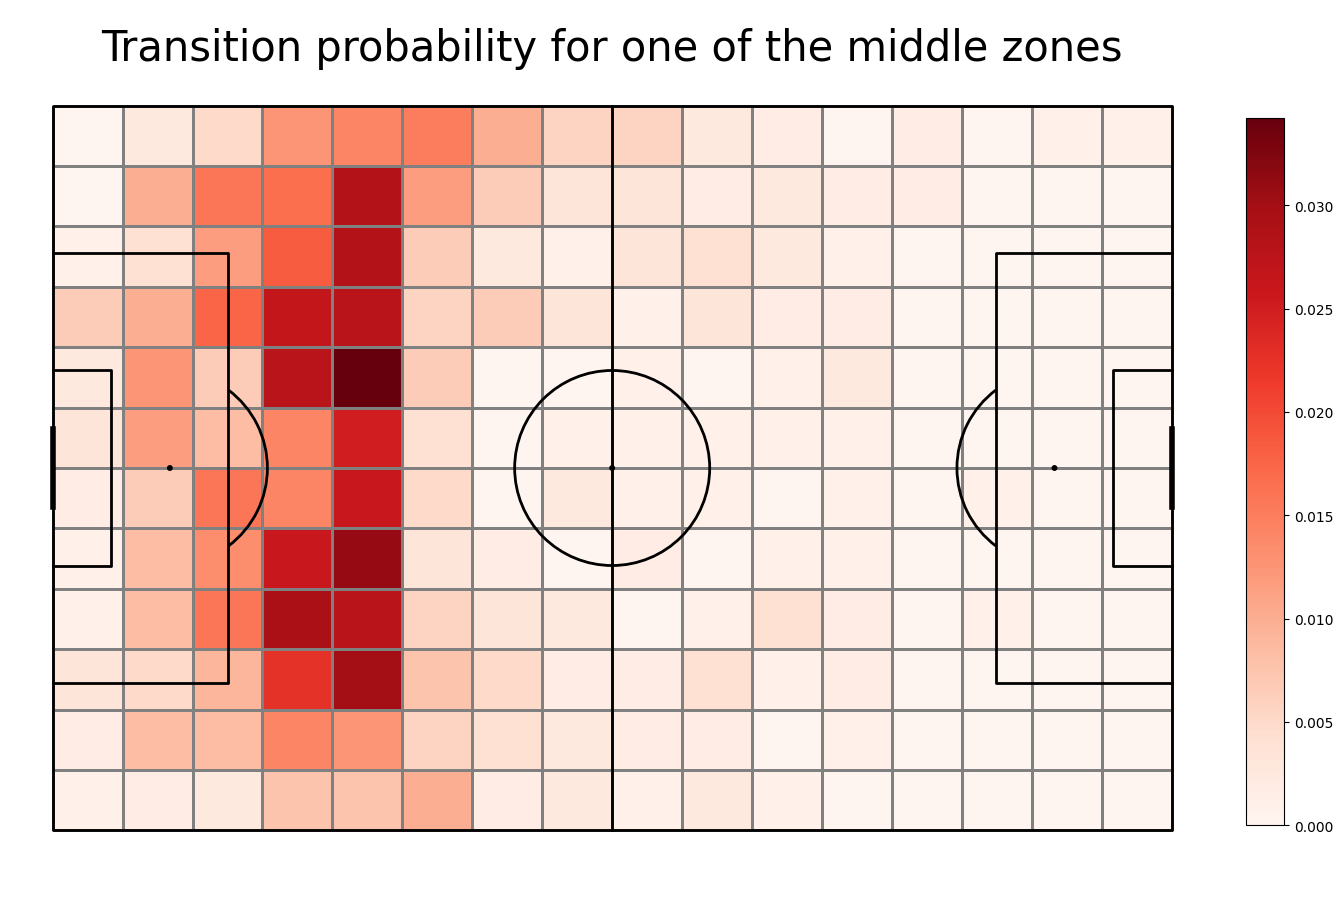

In [126]:
# Init pitch
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)

# Change the index here to change the zone
goal["statistic"] = transition_matrices[17]

pcm  = pitch.heatmap(goal, cmap='Reds', edgecolor='grey', ax=ax['pitch'])

# Add legend to plot
ax_cbar = fig.add_axes((1, 0.093, 0.03, 0.786))
cbar = plt.colorbar(pcm, cax=ax_cbar)

fig.suptitle('Transition probability for one of the middle zones', fontsize = 30)
plt.show()


# Calculating xT matrix

Iterating method gebruiken om tot finale xT waarde te komen

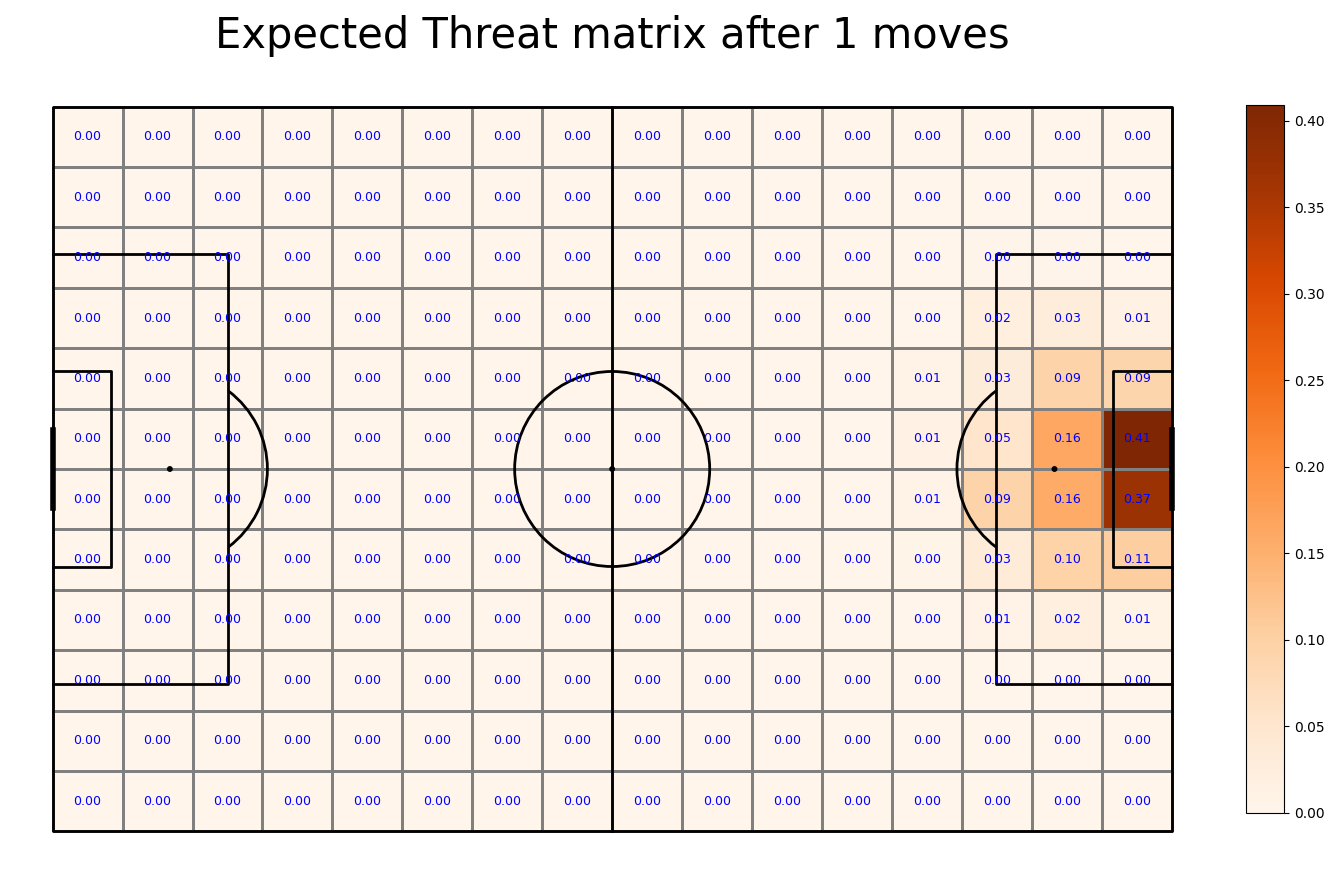

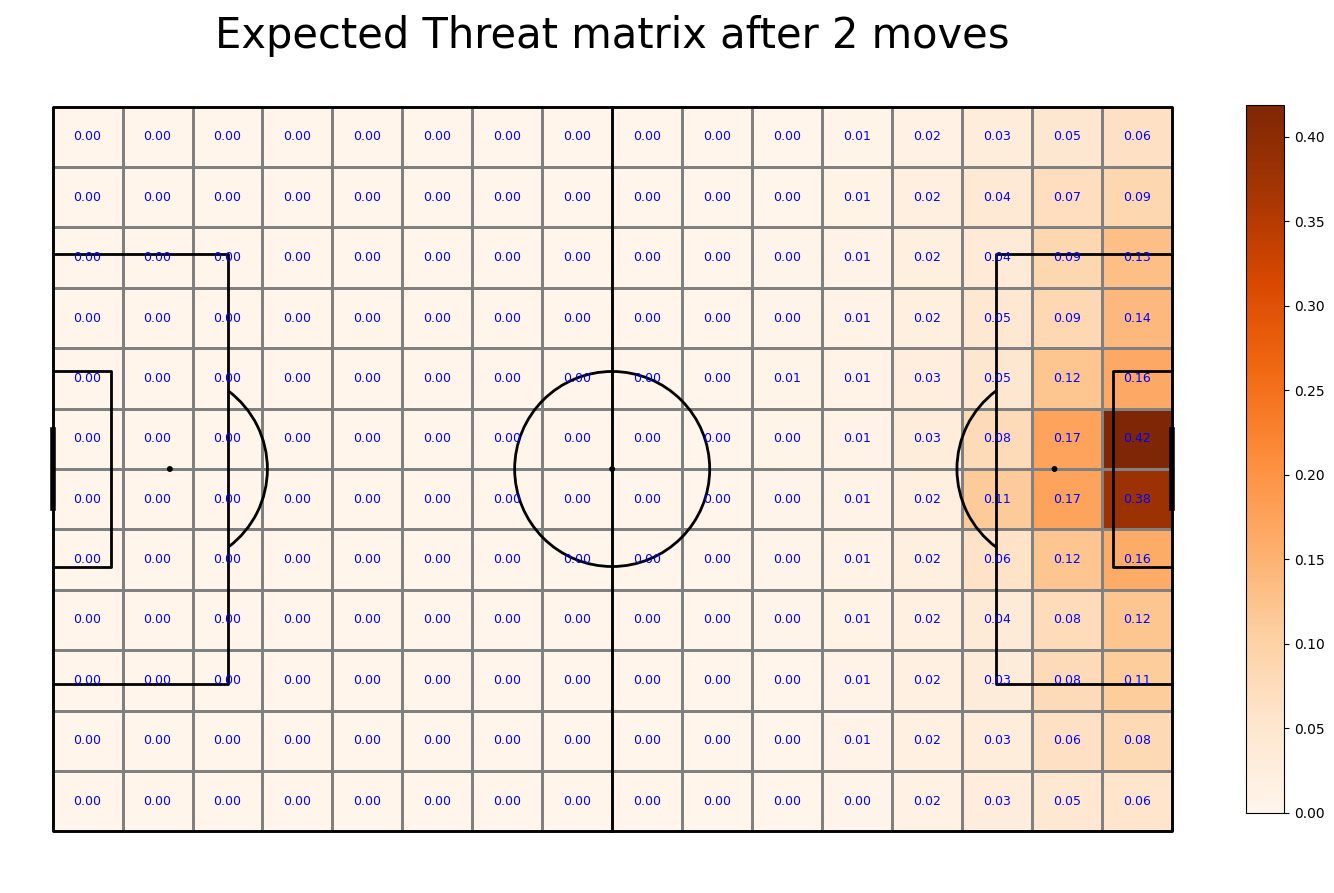

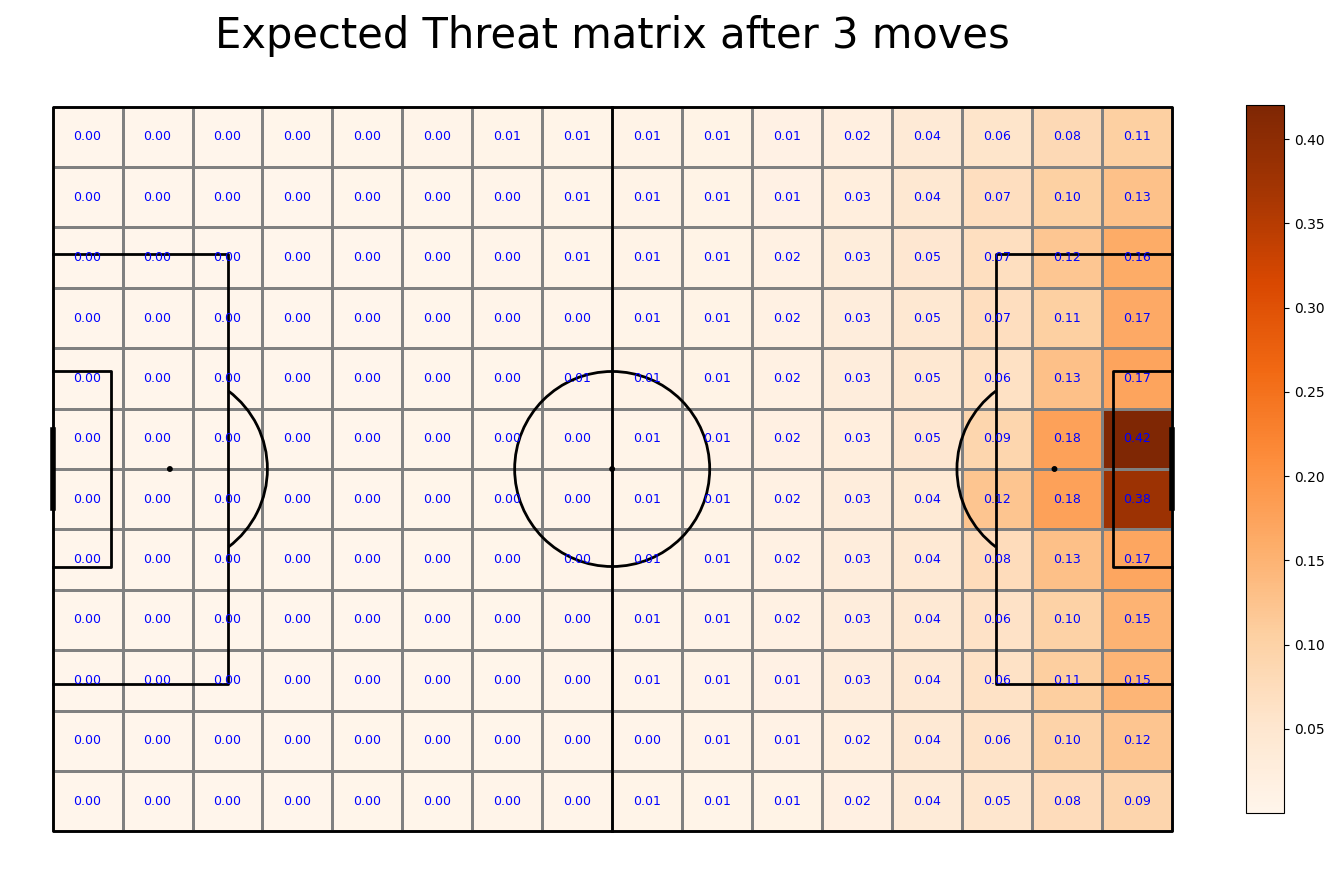

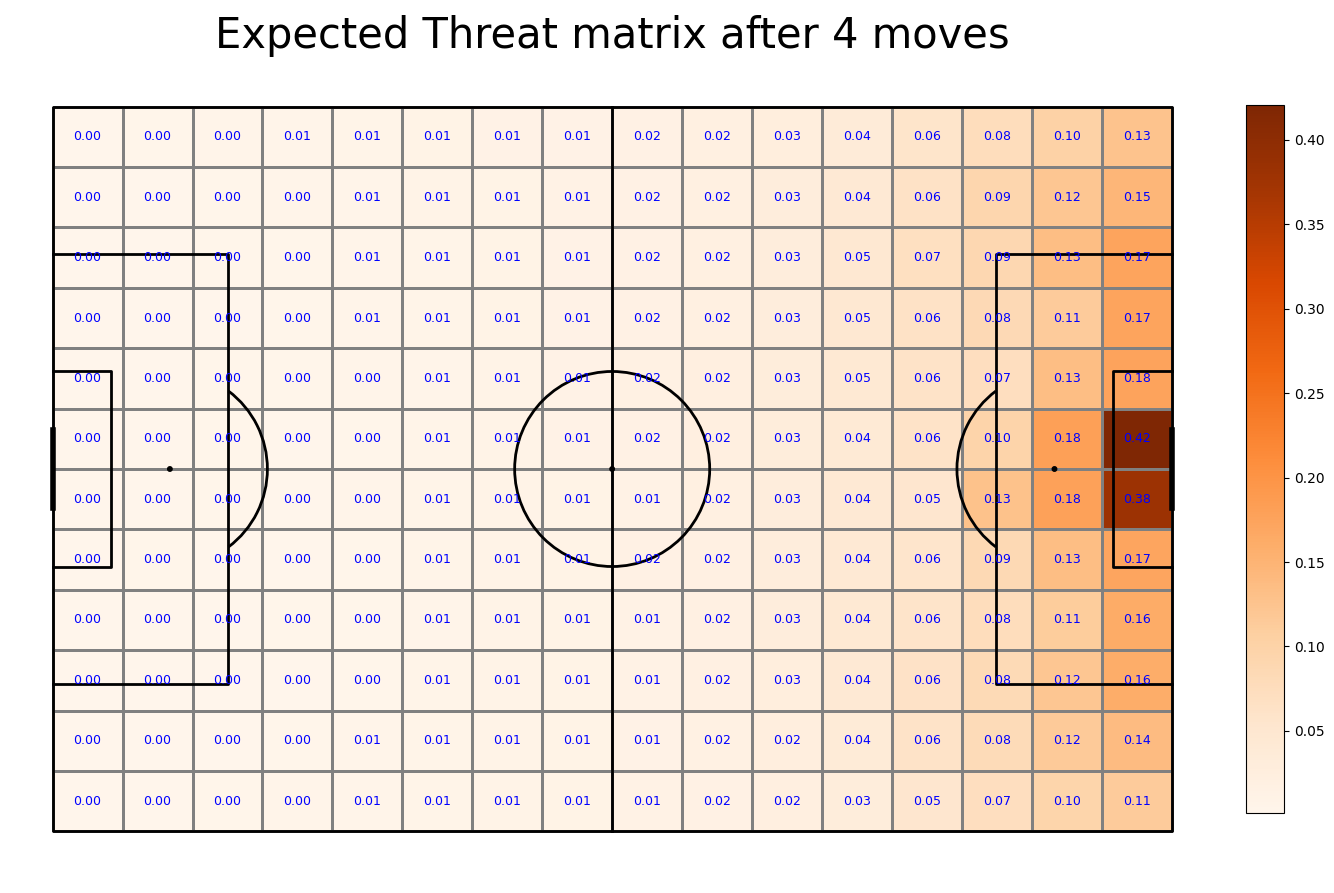

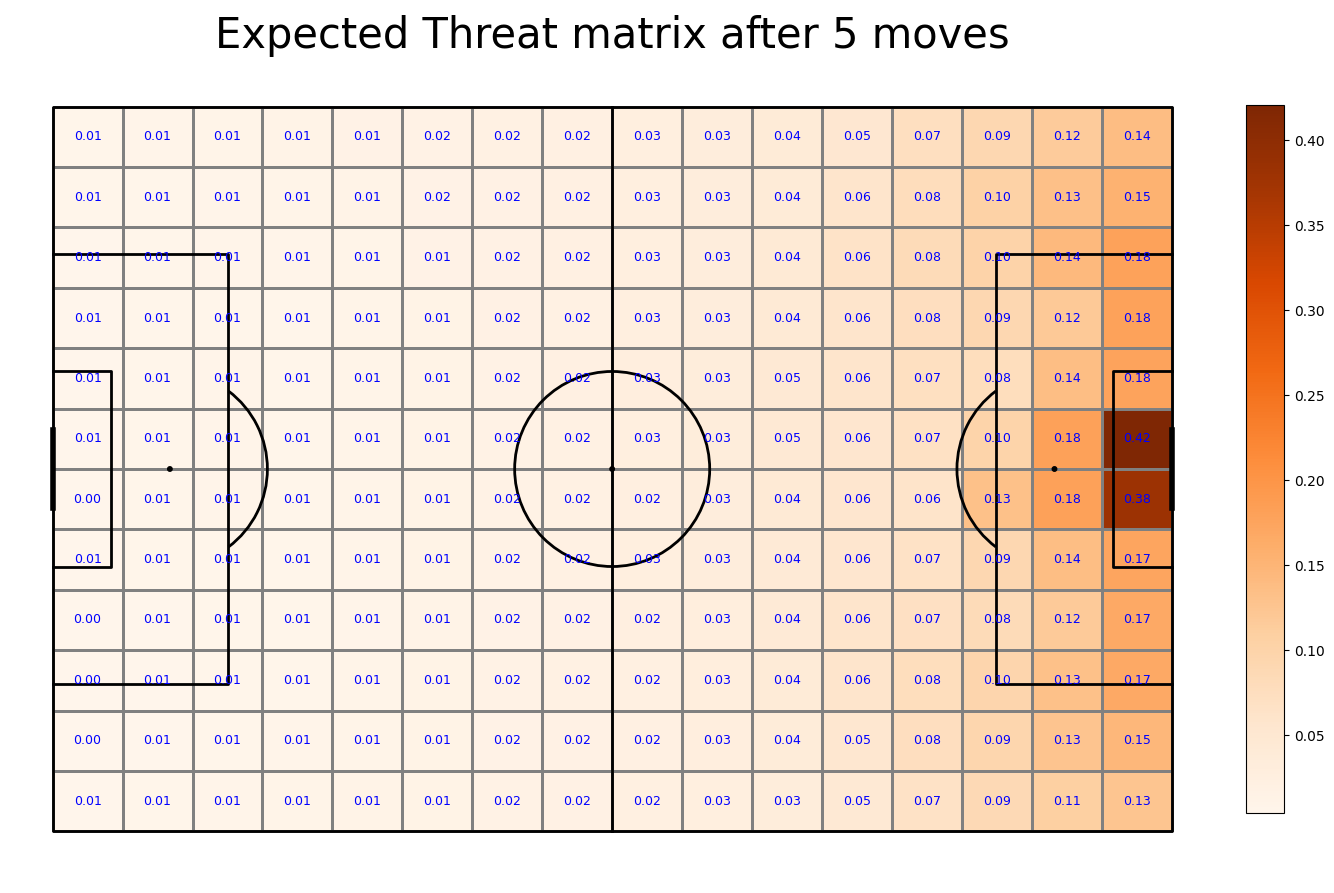

In [127]:
transition_matrices_array = np.array(transition_matrices)

xT = np.zeros((12, 16))

for i in range(5):
    # Calculate probability of a shot being scored right away
    shoot_expected_payoff = goal_prob * shot_prob

    # Calculate probability of a goal after a move
    move_expected_payoff = move_prob * (np.sum(np.sum(transition_matrices_array * xT, axis = 2), axis = 1).reshape(16,12).T)

    xT = shoot_expected_payoff + move_expected_payoff

    # Init plot
    fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.01, title_space=0, endnote_space=0)
    
    # Use xT as statistic
    goal["statistic"] = xT

    # Create heatmap
    pcm  = pitch.heatmap(goal, cmap='Oranges', edgecolor='grey', ax=ax['pitch'])
    
    # Add labels (xT values for each bin)
    labels = pitch.label_heatmap(goal, color='blue', fontsize=9,
                             ax=ax['pitch'], ha='center', va='center', str_format="{0:,.2f}", zorder = 3)

    # Add legend
    ax_cbar = fig.add_axes((1, 0.093, 0.03, 0.786))
    cbar = plt.colorbar(pcm, cax=ax_cbar)
    
    txt = 'Expected Threat matrix after ' +  str(i+1) + ' moves'
    fig.suptitle(txt, fontsize = 30)
    plt.show()